(dl/01b-linear)=
# Linear classification

Neural networks learn to classify by finding separating hyperplanes obtained after a sequence of transformations on the input[^1]. The distance of a data point to each hyperplane are interpreted as unnormalized class scores and are called **logits**. Note that instead of hard labels, we want to predict a probability distribution over class labels since this is differentiable. This can be done by applying an increasing positive function $f: \mathbb{R} \to \mathbb{R}^+$ to class scores to convert it to a probability vector:

$$p_j = \frac{f(s_j)}{\sum_k f(s_k)}.$$

[^1]: The intermediate outputs are called representations.

A natural choice is the [exponential](https://en.wikipedia.org/wiki/Exponential_function) $f(s) = e^s$ which maps $\mathbb R$ to $\mathbb R^+$ one-to-one with $e^{-\infty} = 0.$ The resulting function is called the **softmax function**[^2]. Float division in softmax can be stabilized by dividing the numerator and denominator with the largest term so that its demoninator is at least 1. Hence:

$$\text{Softmax}(\boldsymbol{\mathsf{s}})_j = \frac{e^{s_j - s_*}}{\sum_k e^{s_k - s_*}} \quad \text{where}\;\; s^* = \max_j s_j.$$

For binary classification, we only have to compute the probability of one class since $p_0 + p_1 = 1.$
In this case, we recover the **sigmoid function**: $p_1 = {1}/\left(1 + e^{-(s_1 - s_0)}\right)$ for the probability of the positive label. Notice that [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) can be implemented as a single layer neural network with $s_k = \boldsymbol{\mathsf{w}}_k \cdot \boldsymbol{\mathsf{x}} + b_k$, so that we get fused weights and biases:

$$s_1 - s_0 = (\boldsymbol{\mathsf{w}}_1 - \boldsymbol{\mathsf{w}}_0) \cdot \boldsymbol{\mathsf{x}} + (b_1 - b_0),$$ 

i.e. one separating hyperplane.

[^2]: Perhaps a better name is soft-*arg*max since exponentiation highlights the index with the largest score.

In [1]:
import numpy as np

s = np.linspace(-10, 10, 300)
p = 1 / (1 + np.exp(-s))

p_inv = lambda p: np.log(p / (1 - p))
threshold = 0.15
s_lo = p_inv(threshold)
s_hi = p_inv(1 - threshold)

s0 = [-8.0, -7.8, -6.5, -5.0, -2.5, -1.25, 0.3, -7.6]   # y = 0
s1 = [-2.2,  0.0,  6.0,  1.3,  5.0,   7.5, 7.6,  8.3]   # y = 1

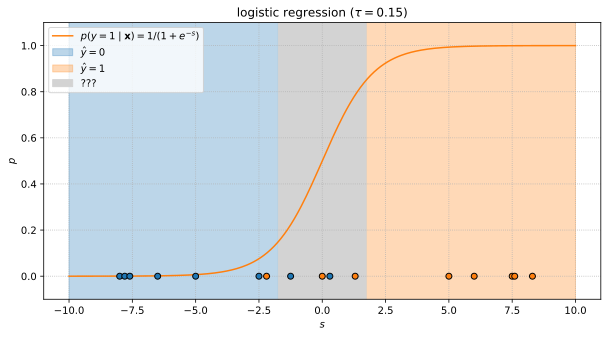

In [2]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

plt.figure(figsize=(10, 5))
plt.title(r"logistic regression ($\tau = 0.15$)")
plt.plot(s, p, label="$p(y=1 \mid {\mathbf{x}}) = 1 / (1 + e^{-s})$", color="C1")
for i in range(len(s0)):
    plt.scatter(s0[i], 0.0, color="C0", zorder=3, edgecolor='k')
    plt.scatter(s1[i], 0.0, color="C1", zorder=3, edgecolor='k')

plt.axvspan(-10.0, s_lo, -2.0, 2.0, color='C0', label=r"$\hat{y} = 0$", alpha=0.3)
plt.axvspan( s_hi, 10.0, -2.0, 2.0, color='C1', label=r"$\hat{y} = 1$", alpha=0.3)
plt.axvspan( s_lo, s_hi, -2.0, 2.0, color='lightgray', label="???")
plt.xlabel("$s$")
plt.ylabel("$p$")
plt.legend()
plt.ylim(-0.1, 1.1)
plt.grid(linestyle="dotted");

Note that the sigmoid assigns $p =\frac{1}{2}$ at the hyperplane where $s = 0.$ It scales symmetrically with respect to the distance of the data points from the decision boundary. This is nice otherwise the prediction will not be invariant with respect to relabeling. For the general case of multiclass classification, we will have class scores $s_k = \boldsymbol{\mathsf{w}}_k \cdot \boldsymbol{\mathsf{x}}$ and the softmax will act like a **voting function**. See [this video](https://www.youtube.com/watch?v=p-6wUOXaVqs) for deeper reasons on using the softmax function.

In [3]:
# grid of points
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# parameters
w = [1, 1]
b = 0

def sigmoid_neuron(x, y):
    z = w[0] * x + w[1] * y + b
    return 1 / (1 + np.exp(-z))

def relu_neuron(x, y):
    z = w[0] * x + w[1] * y + b
    return np.maximum(0, z)

The sigmoid unit assigns a gradient along the normal of the hyperplane defined by $\boldsymbol{\mathsf{w}}$ and $b$ in the input space $\mathbb{R}^2$. This effectively reduces the input
space to one dimension along the direction of ${\boldsymbol{\mathsf{w}}} = [1, 1].$ Here $H$ is the linear decision boundary defined by points $\boldsymbol{\mathsf{x}}$ such that $\boldsymbol{\mathsf{x}} \cdot \boldsymbol{\mathsf{w}} + b = 0.$ ReLU unit has sharp cutoff at zero.

In [4]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["C0", "C1"]
n_bins = 100
cm = LinearSegmentedColormap.from_list(name="", colors=colors, N=n_bins)

def plot_grid(ax, X, Y, Z, title=""):
    p1 = (-0.45, -0.45)
    p2 = (1, 1)
    ax.annotate(f'$\mathsf{{w}}$', xy=p2, xytext=p1, arrowprops=dict(arrowstyle='->'))
    ax.plot(x, -x, color='k', linewidth=1, linestyle='dotted', label='H')

    im = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cm, rasterized=True)
    cbar = plt.colorbar(im, ax=ax)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(title, size=12)
    ax.legend()

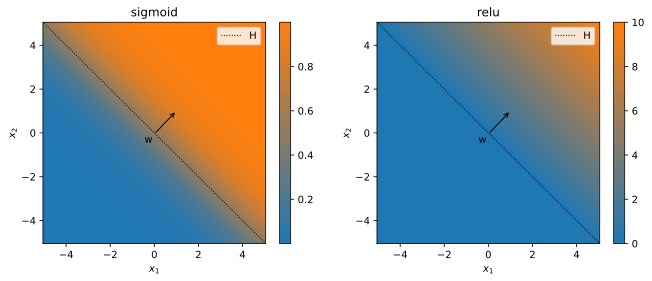

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
Z0 = sigmoid_neuron(X, Y)
Z1 = relu_neuron(X, Y)
plot_grid(ax[0], X, Y, Z0, title="sigmoid")
plot_grid(ax[1], X, Y, Z1, title="relu")

Another way to think about this is that a weight vector $\boldsymbol{\mathsf{w}}$ corresponds to a learned pattern, so that the projection $\boldsymbol{\mathsf{x}} \cdot \boldsymbol{\mathsf{w}}$ of the input $\boldsymbol{\mathsf{x}}$ to $\boldsymbol{\mathsf{w}}$ corresponds to a scaled similarity. The activation function determines whether this plus the bias $b$ is enough to activate the unit. 